In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

import astropy.io.fits as fits

import glob

import os

from photutils.aperture import EllipticalAperture
from photutils.aperture import EllipticalAnnulus
from photutils import aperture_photometry

from matplotlib.colors import LogNorm

# Starting with M101:

In [2]:
# filepath just for M101 observations:

filepath = glob.glob('./fits/ARCSAT/5-19/M49*.fits')

In [3]:
# getting copies of data and headers for M49; prints filenames as well as headers for first two:

data_array = []
header_array = []

for file in filepath:

    hdu = fits.open(file)
    data_array.append(hdu[0].data.copy())
    header_array.append(hdu[0].header.copy())
    print(os.path.basename(file))

hdu.close()
header_array[0]

M49_halpha_20180520_043609.fits
M49_sdss_g_20180520_032008.fits
M49_sdss_g_20180520_032646.fits
M49_sdss_g_20180520_033454.fits
M49_sdss_i_20180520_040512.fits
M49_sdss_r_20180520_034825.fits
M49_sdss_z_20180520_041554.fits


SIMPLE  =                    T                                                  
BITPIX  =                   16 /8 unsigned int, 16 & 32 int, -32 & -64 real     
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4096 /fastest changing axis                           
NAXIS2  =                 4096 /next to fastest changing axis                   
BSCALE  =   1.0000000000000000 /physical = BZERO + BSCALE*array_value           
BZERO   =   32768.000000000000 /physical = BZERO + BSCALE*array_value           
DATE-OBS= '2018-05-20T04:36:22' / [ISO 8601] UTC date/time of exposure start    
EXPTIME =   7.50000000000E+002 / [sec] Duration of exposure                     
EXPOSURE=   7.50000000000E+002 / [sec] Duration of exposure                     
SET-TEMP=  -31.399999618530273 /CCD temperature setpoint in C                   
CCD-TEMP=  -29.018484000000001 /CCD temperature at start of exposure in C       
XPIXSZ  =   9.00000000000000

In [4]:
plt.style.use('default')

In [5]:
# lazy image reduction:

crude_i = data_array[4]-np.mean(data_array[4])
crude_r = data_array[5]-np.mean(data_array[5])
crude_g = data_array[3]-np.mean(data_array[3])

In [6]:
from astropy.visualization import make_lupton_rgb

In [7]:
color_image = make_lupton_rgb(crude_r, crude_g, crude_i, stretch=800)

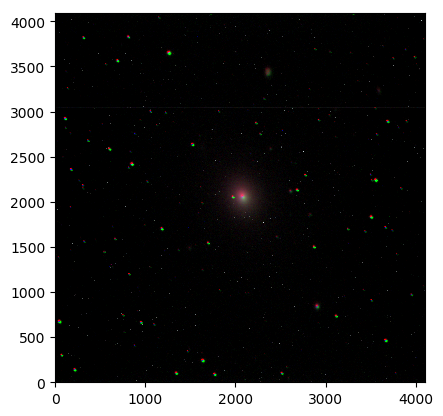

In [8]:
plt.imshow(color_image, norm=LogNorm(vmin=500), origin='lower', cmap='rainbow');

In [9]:
from astropy import stats

In [10]:
clip_star = stats.sigma_clip(data_array[1], sigma=5, iters=5)
clip_color = stats.sigma_clip(color_image, sigma=5, iters=5)

In [11]:
copy_data = np.copy(data_array[1])
color_copy = np.copy(color_image)

copy_data[~clip_star.mask] = data_array[1].min()
color_copy[~clip_color.mask] = color_image.min()

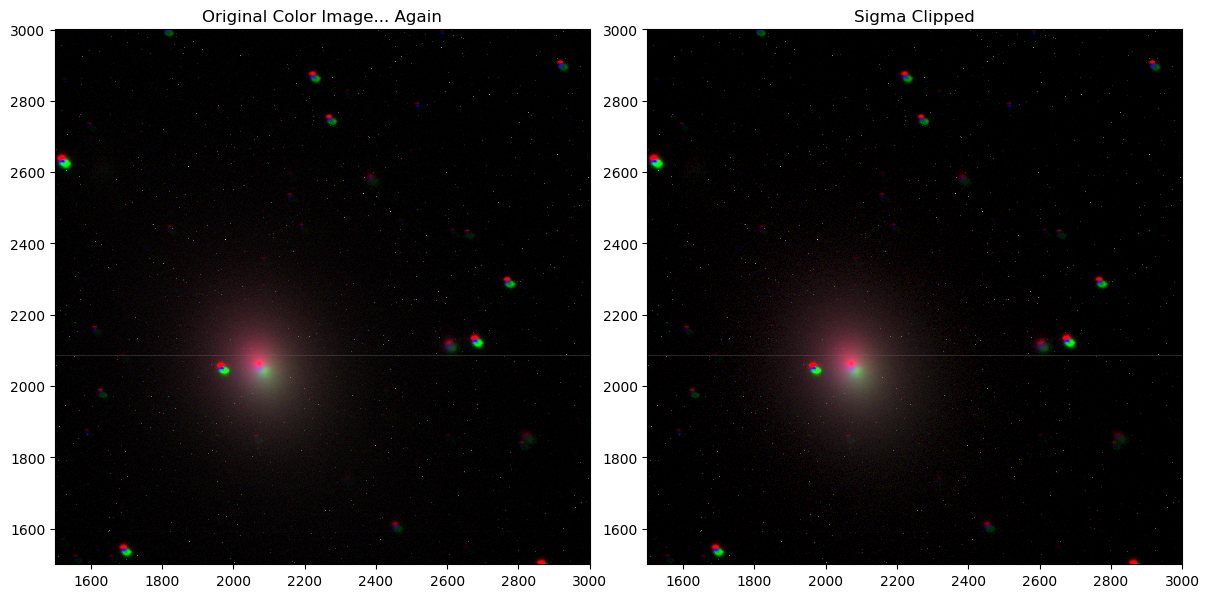

In [12]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[0].axis((1500,3000,1500,3000))
ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(color_image, norm=LogNorm(vmin=200), origin='lower', cmap='rainbow')
ax[1].imshow(color_copy, norm=LogNorm(vmin=200), origin='lower', cmap='rainbow')
ax[0].set_title('Original Color Image... Again')
ax[1].set_title('Sigma Clipped');

# Okay now to actually import the biases and flats:

In [13]:
# Night 1 Bias Filepath:

filepath2 = glob.glob('./fits/ARCSAT/5-19/Bias*.fits')

In [14]:
# Retrieves night 1 bias stuff; prints filenames & returns avg. bias count.

biasdata_array = []
biasheader_array = []
bias_avgs = []
superbias = []

for file in filepath2:

    hdu1 = fits.open(file)
    biasdata_array.append(hdu1[0].data.copy())
    biasheader_array.append(hdu1[0].header.copy())
    print(os.path.basename(file))
    bdata = fits.getdata(file)
    bias_avgs.append(np.mean(bdata))

super_bias = np.mean(bias_avgs)

hdu1.close()
print(super_bias)

Bias_BIN1_20180520_082435.fits
Bias_BIN1_20180520_082510.fits
Bias_BIN1_20180520_082533.fits
Bias_BIN1_20180520_082555.fits
Bias_BIN1_20180520_082622.fits
1131.0744609951973


In [15]:
# Filepath for night 1 dome flats.

filepath3 = glob.glob('./fits/ARCSAT/5-19/domeflat*.fits')

In [16]:
# Getting dome flat stuff:

domeflatdata_array = []
domeflatheader_array = []

for file in filepath3:

    hdu2 = fits.open(file)
    domeflatdata_array.append(hdu2[0].data.copy())
    domeflatheader_array.append(hdu2[0].header.copy())
    print(os.path.basename(file))

hdu2.close()

domeflat_halpha_001.fits
domeflat_sdss_g_001-2.fits
domeflat_sdss_g_002-2.fits
domeflat_sdss_g_003-2.fits
domeflat_sdss_i_001.fits
domeflat_sdss_i_002.fits
domeflat_sdss_i_003.fits
domeflat_sdss_r_001.fits
domeflat_sdss_r_002.fits
domeflat_sdss_r_003.fits
domeflat_sdss_z_001.fits


In [17]:
# sdss_i avg. flat count:

iflat_avg = np.mean(domeflatdata_array[4:7])
print(iflat_avg)

19478.75809923808


# Now for actual data reduction (of M49):

In [18]:
# subtract biases - from everything,
# divide flats

In [19]:
from sklearn.preprocessing import normalize

In [20]:
# making average i band flat:

i_avg_flats = (domeflatdata_array[4] + domeflatdata_array[5] + domeflatdata_array[6])/3

In [21]:
i_avg_flats_minusbias = i_avg_flats - super_bias

In [22]:
# normalizing i band flat:

n2_domeflatnorm_i = i_avg_flats_minusbias/np.linalg.norm(i_avg_flats_minusbias)

In [23]:
reduced_i_M49 = (data_array[4] - super_bias)/(n2_domeflatnorm_i)

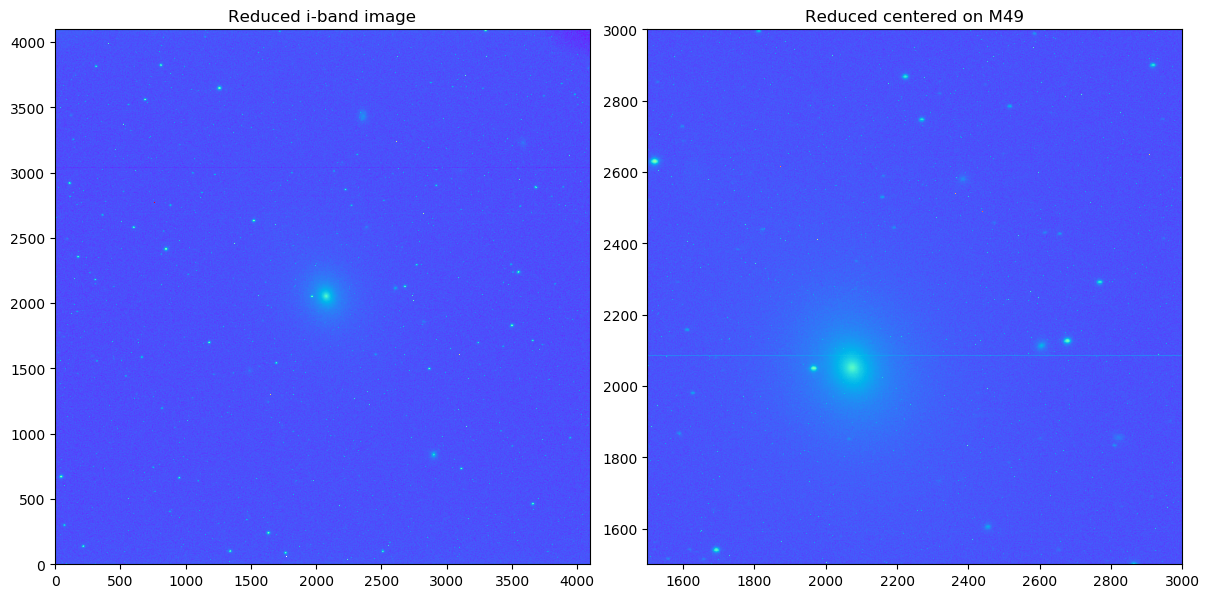

In [24]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_i_M49, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_i_M49, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced i-band image')
ax[1].set_title('Reduced centered on M49');

In [25]:
r_avg_flats = (domeflatdata_array[7] + domeflatdata_array[8] + domeflatdata_array[9])/3

In [26]:
rflat_minusbias = r_avg_flats - super_bias

In [27]:
n2_domeflatnorm_r = rflat_minusbias/np.linalg.norm(rflat_minusbias)

In [28]:
reduced_r_M49 = (data_array[5] - super_bias)/(n2_domeflatnorm_r)

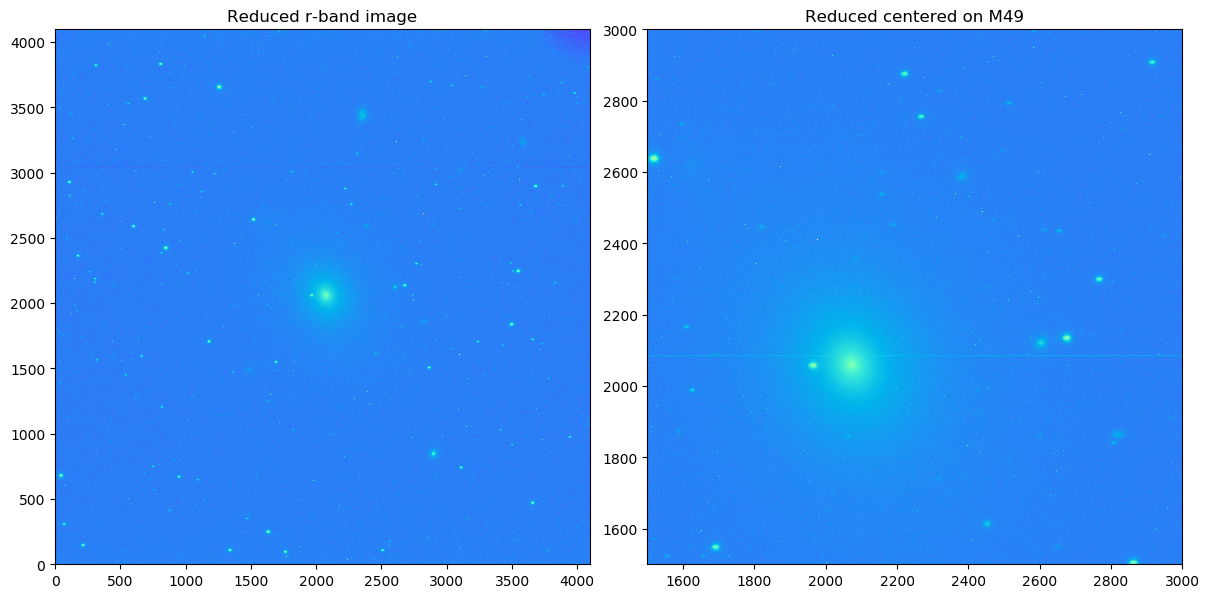

In [29]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_r_M49, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_r_M49, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced r-band image')
ax[1].set_title('Reduced centered on M49');

In [30]:
# g band

g_avg_flats_minusbias = ((domeflatdata_array[1] + domeflatdata_array[2] + domeflatdata_array[3])/3) - super_bias

n2_domeflatnorm_g = g_avg_flats_minusbias/np.linalg.norm(g_avg_flats_minusbias)

reduced_g_M49 = (data_array[3] - super_bias)/(n2_domeflatnorm_g)

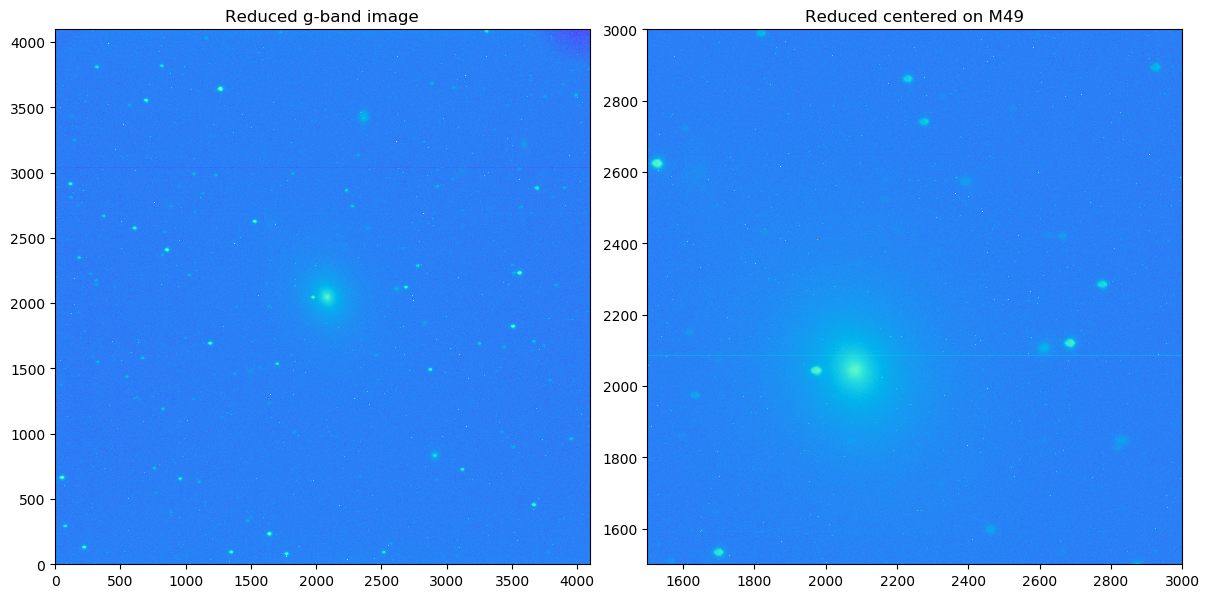

In [31]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_g_M49, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_g_M49, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced g-band image')
ax[1].set_title('Reduced centered on M49');

In [32]:
# z band

z_avg_flats_minusbias = domeflatdata_array[10] - super_bias

n2_domeflatnorm_z = z_avg_flats_minusbias/np.linalg.norm(z_avg_flats_minusbias)

reduced_z_M49 = (data_array[6] - super_bias)/(n2_domeflatnorm_z)

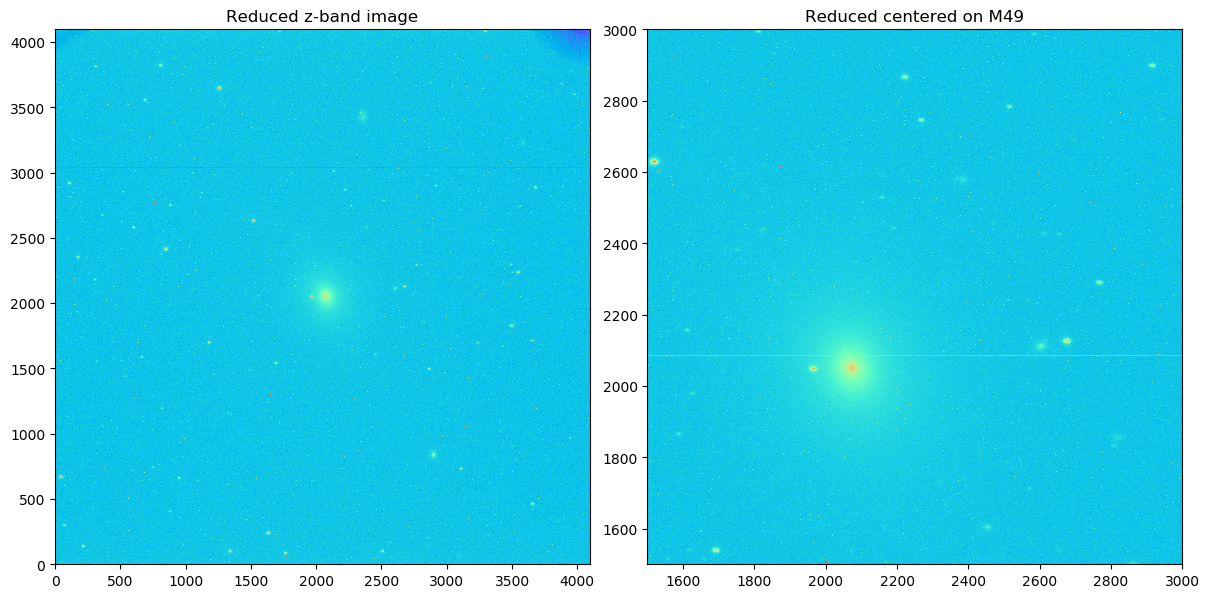

In [33]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_z_M49, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_z_M49, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced z-band image')
ax[1].set_title('Reduced centered on M49');

In [34]:
halpha_avg_flats_minusbias = domeflatdata_array[0] - super_bias

n2_domeflatnorm_halpha = halpha_avg_flats_minusbias/np.linalg.norm(halpha_avg_flats_minusbias)

reduced_halpha_M49 = (data_array[0] - super_bias)/(n2_domeflatnorm_halpha)

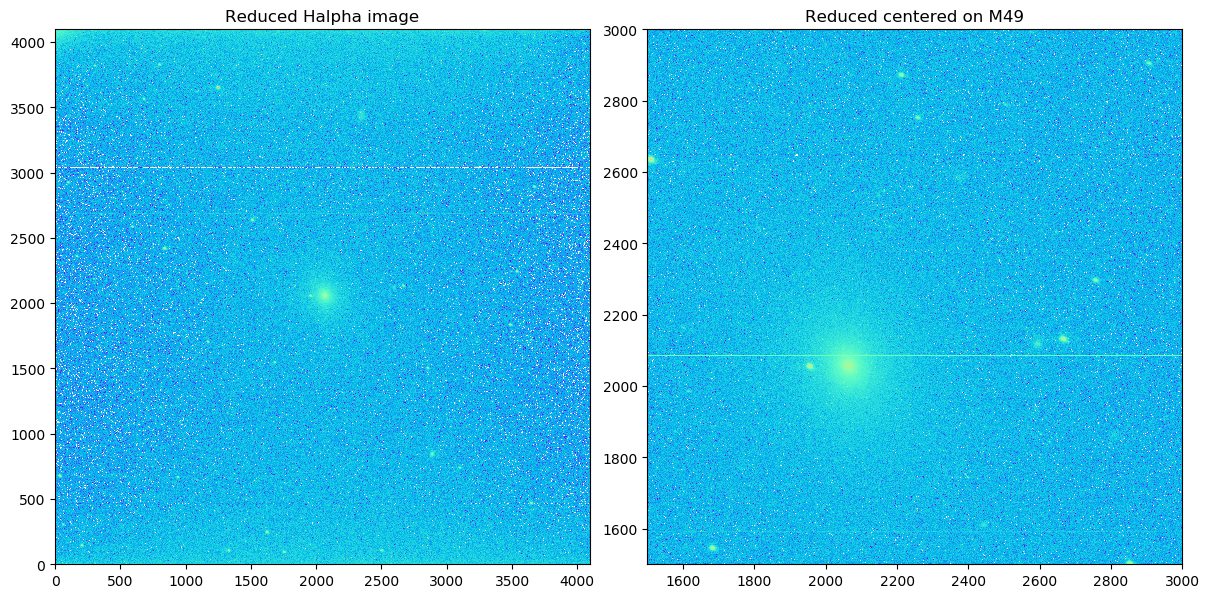

In [35]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_halpha_M49, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_halpha_M49, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced Halpha image')
ax[1].set_title('Reduced centered on M49');

# Now for sky-subtraction:

In [36]:
coord = [2051.134, 2053.268]

In [37]:
ApertureScience = EllipticalAperture(coord, a=300, b=200, theta=1.7)

In [38]:
ap_pho = aperture_photometry(reduced_i_M49, ApertureScience, method='exact')
ap_pho

<QTable length=1>
  id  xcenter  ycenter     aperture_sum  
        pix      pix                     
int64 float64  float64       float64     
----- -------- -------- -----------------
    1 2051.134 2053.268 211726164854.6233

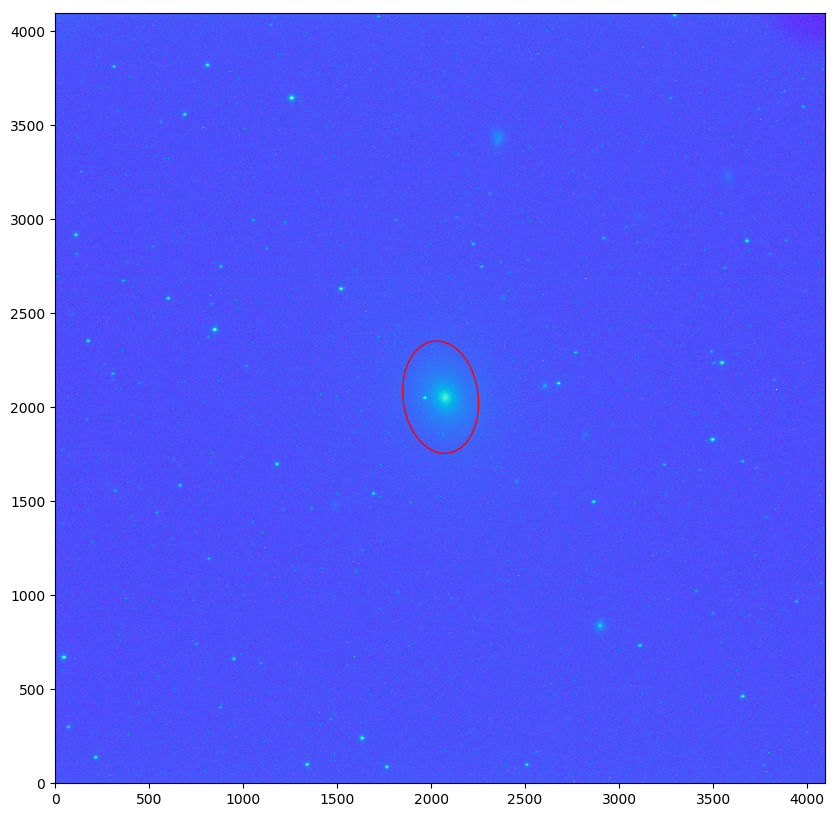

In [39]:
fig,ax = plt.subplots(1,1)                 
fig.set_size_inches(10,10)
fig.set_tight_layout

plt.imshow(reduced_i_M49, norm=LogNorm(), alpha=1.0, cmap='rainbow', origin='lower')
EllipticalAperture.plot(ApertureScience, color="r");

In [40]:
count = []

count_a = ap_pho['aperture_sum']
count_per_area = (count_a / (ApertureScience.area())) # counts / pixel squared
count.append(count_per_area)
print(count)

[<Column name='aperture_sum' dtype='float64' length=1>
1123242.1906167606]


In [41]:
# That can't be right.

In [42]:
coord2 = [3318.906, 1504.755]

In [43]:
Elliptical_Annulus_Science = EllipticalAnnulus(coord2, a_in=.1, a_out=.2, b_out=.1, theta=0)

In [44]:
ell_ann_phot = aperture_photometry(reduced_i_M49, Elliptical_Annulus_Science, method='exact')
ell_ann_phot # no...

<QTable length=1>
  id  xcenter  ycenter     aperture_sum   
        pix      pix                      
int64 float64  float64       float64      
----- -------- -------- ------------------
    1 3318.906 1504.755 20671.593617049984

# Also M100 as it's only two filters so doesn't take up a whole notebook's worth of space:

In [45]:
filepath_M100 = glob.glob('./fits/ARCSAT/5-19/M100*.fits')

In [46]:
M100data_array = []
M100header_array = []

for file in filepath_M100:

    hdu = fits.open(file)
    M100data_array.append(hdu[0].data.copy())
    M100header_array.append(hdu[0].header.copy())
    print(os.path.basename(file))

hdu.close()

M100_sdss_g_20180520_060503.fits
M100_sdss_g_20180520_061044.fits
M100_sdss_g_20180520_073558.fits
M100_sdss_g_20180520_074000.fits
M100_sdss_r_20180520_075851.fits


In [47]:
# g band M100

reduced_g_M100 = (M100data_array[3] - super_bias)/(n2_domeflatnorm_g)

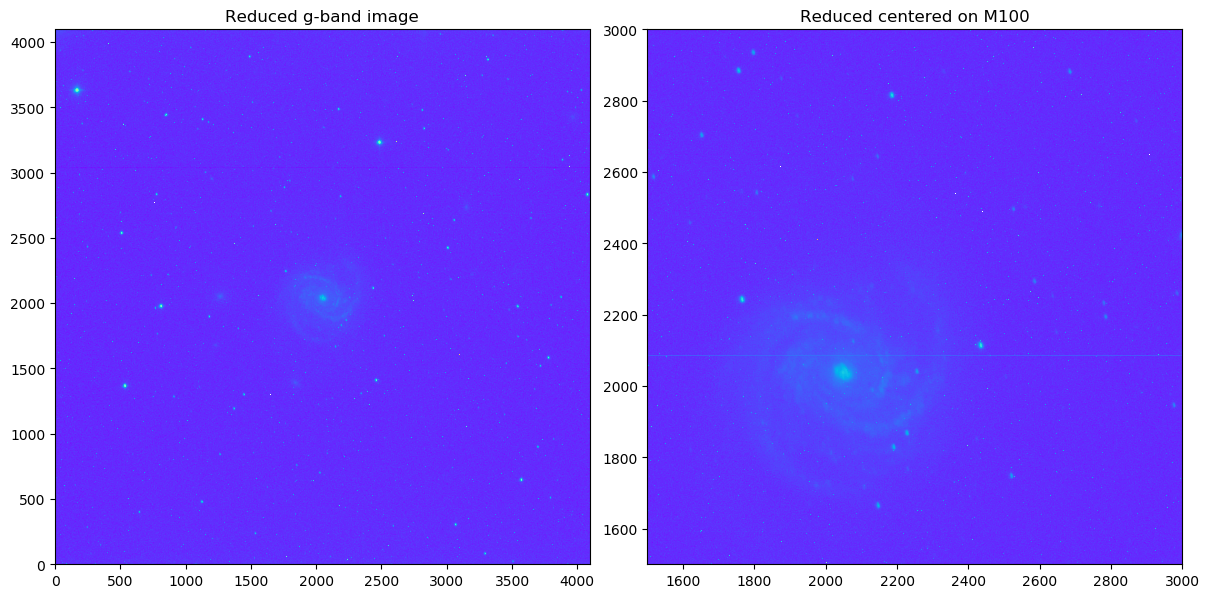

In [48]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_g_M100, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_g_M100, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced g-band image')
ax[1].set_title('Reduced centered on M100');

In [49]:
reduced_r_M100 = (M100data_array[4] - super_bias)/(n2_domeflatnorm_r)

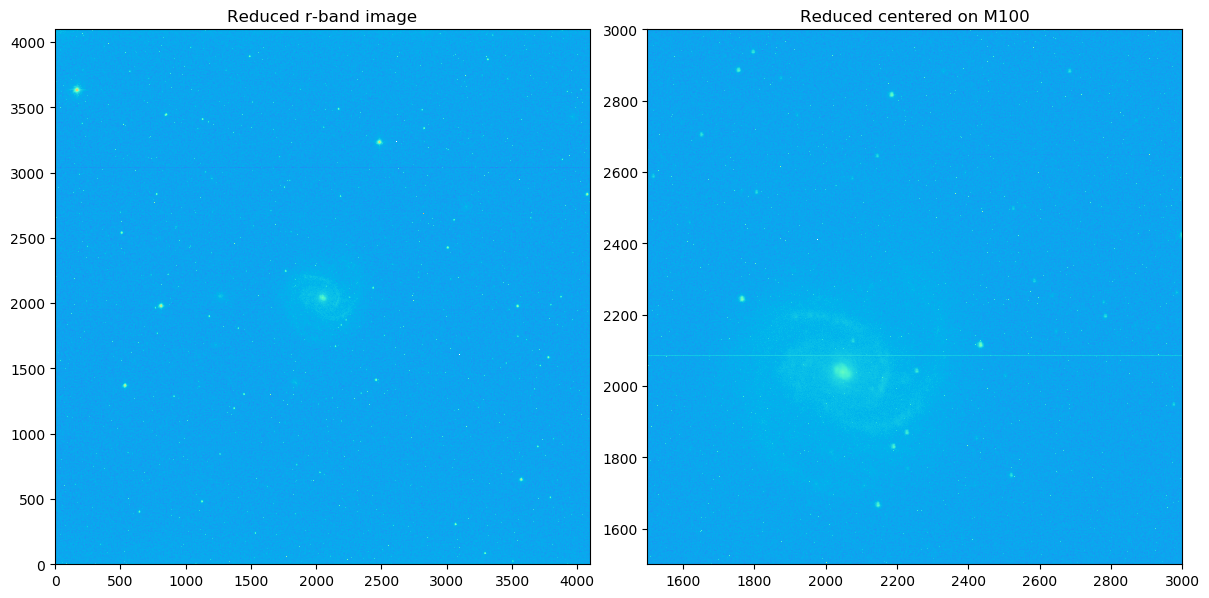

In [50]:
fig, ax = plt.subplots(1,2)

fig.set_size_inches(12,6)

fig.tight_layout()

ax[1].axis((1500,3000,1500,3000))

ax[0].imshow(reduced_r_M100, norm=LogNorm(), origin='lower', cmap='rainbow')
ax[1].imshow(reduced_r_M100, norm=LogNorm(), origin='lower', cmap='rainbow')

ax[0].set_title('Reduced r-band image')
ax[1].set_title('Reduced centered on M100');